In [1]:
import pandas as pd
import numpy as np
from py_files.data_manager import get_X_y
from py_files.features import distance, generate_features
from config import data_path
import json

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, r2_score
import time
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
pd.options.display.float_format = '{:.6f}'.format

In [2]:
# X, y = get_X_y(force_clean=True)
X, y = get_X_y()
X = generate_features(X)
X['pickup_datetime'] = pd.to_datetime(X['pickup_datetime'])

/Users/dylanskinner/Desktop/ACME_Projects/NYC_Taxi_Trip_Duration/py_files/data_manager.py:69: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df_clean['pickup_datetime_norm'] = pd.to_datetime(df_clean['pickup_datetime']).astype('int64') // 10**9


In [4]:
d = pd.read_csv(data_path + '/train_clean.csv')
d

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,...,pickup_day_Tuesday,pickup_day_Wednesday,pickup_hour,pickup_minute,pickup_period_morning,pickup_period_afternoon,pickup_period_evening,pickup_hour_sin,pickup_hour_cos,pickup_datetime_norm
0,id2875421,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,455,3,...,0,0,17,24,0,1,0,-0.965926,-0.258819,0.405086
1,id2377394,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,663,6,...,0,0,0,43,0,0,0,0.000000,1.000000,0.895772
2,id3858529,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,...,1,0,11,35,1,0,0,0.258819,-0.965926,0.101554
3,id3504673,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,429,4,...,0,1,19,32,0,0,1,-0.965926,0.258819,0.531947
4,id2181028,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,435,3,...,0,0,13,30,0,1,0,-0.258819,-0.965926,0.470127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,1,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,778,4,...,0,0,13,31,0,1,0,-0.258819,-0.965926,0.541556
1458640,id1049543,0,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,655,1,...,0,0,7,35,1,0,0,0.965926,-0.258819,0.051187
1458641,id2304944,1,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,764,4,...,0,0,6,57,0,0,0,1.000000,0.000000,0.616979
1458642,id2714485,0,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,373,1,...,1,0,15,56,0,1,0,-0.707107,-0.707107,0.025626


In [20]:
from sklearn import linear_model
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X1 = X.drop(columns=['id', 'vendor_id', 'pickup_datetime'])

# Get test train split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

lasso_lars_ic = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC(criterion="bic", normalize=False)).fit(X_train, y_train)

results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "BIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")

optimal_alpha = results[results['BIC criterion'] == results['BIC criterion'].min()].index

# Train a Lasso model with the optimal alpha for feature selection
lasso = linear_model.Lasso(alpha=optimal_alpha)
lasso.fit(X_train, y_train)
print(lasso.coef_.round(4))
print(f"Imporant columns: {X_train.columns[lasso.coef_ != 0]}")
print(f'R-squared: {r2_score(y_test, lasso.predict(X_test))}')
pd.DataFrame({'Actual': y_test, 'Predicted': lasso.predict(X_test)})['Predicted'].describe()

[-0.     -0.      0.     -0.     -0.      0.0778 -0.      0.      0.
 -0.     -0.      0.      0.0162  0.0159 -0.      0.     -0.     -0.
 -0.      0.     -0.0367 -0.      0.      0.013 ]
Imporant columns: Index(['pickup_month', 'pickup_hour', 'pickup_minute', 'distance_km',
       'cloudcover (%)'],
      dtype='object')
R-squared: -2.604232092195957e-07


count   288533.000000
mean       827.295981
std          0.642269
min        795.683504
25%        826.833082
50%        827.268480
75%        827.775059
max        828.970851
Name: Predicted, dtype: float64

In [22]:
pd.Series(y_pred).describe()

count   288533.000000
mean       743.743891
std          6.167586
min        650.174214
25%        742.077454
50%        744.052191
75%        744.967307
max        936.741040
dtype: float64

In [32]:
X1 = X.drop(columns=['id', 'vendor_id', 'pickup_datetime'])

# Get test train split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Create param grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [30, 40],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5],
}

# LightGBM
lgb_train = lgb.LGBMRegressor()

# Grid search
grid_search = GridSearchCV(estimator=lgb_train, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best params
print('Best parameters from grid search: ', grid_search.best_params_)


Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best parameters from grid search:  {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.1}


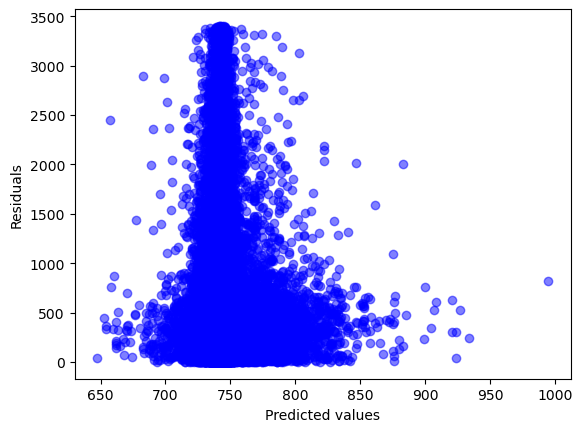

In [27]:
# mean_squared_log_error(y_test, np.exp(y_pred), squared=False)
# PLot residual plot
plt.scatter(y_pred, np.abs(y_pred - y_test), c='blue', marker='o', label='Training data', alpha=0.5)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

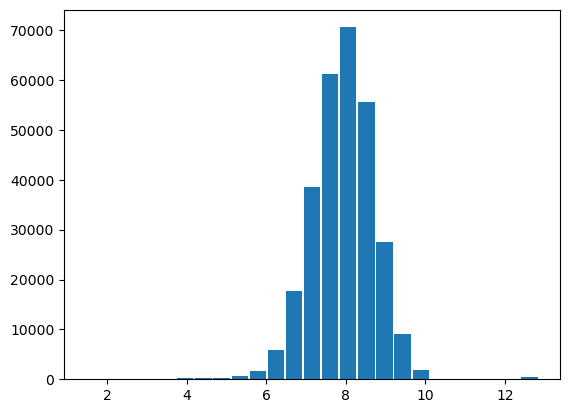

In [53]:
plt.hist(np.abs(y_pred - y_test), bins=25, rwidth=0.9)
plt.show()

In [4]:
# Keep only pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, pickup_month, pickup_hour, pickup_period, distance
# X_c = X[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
#             'pickup_month', 'pickup_hour', 'pickup_period', 'distance_km']]
# X_c = pd.get_dummies(X_c, columns=['pickup_period'], drop_first=True)
# X = X.drop(columns=['id', 'pickup_datetime'])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, max_depth=6, n_jobs=1, random_state=42, verbose=1)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
print(mean_squared_log_error(y_test, y_pred, squared=False))


ValueError: could not convert string to float: 'id0731669'

In [36]:
# Try log transformation of y
y_log = np.log(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Run xgboost regressor on the data.
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, n_jobs=1, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict
y_pred = xgb_reg.predict(X_test)
print(mean_squared_log_error(y_test, y_pred, squared=True))

0.11481842658070009


In [39]:
print(mean_squared_log_error(y_test, y_pred, squared=False))

0.11481842658070009


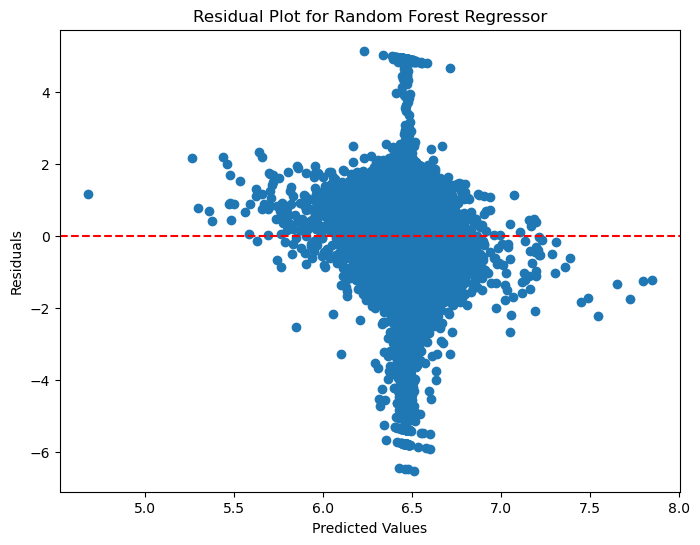

In [40]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residual plot
plt.figure(figsize=(8, 6))
plt.scatter(x=y_pred, y=residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Random Forest Regressor")
plt.show()

In [127]:
json_file_path = './misc/lat_long_bounds.json'
with open(json_file_path, 'r') as json_file:
    # Load the JSON data from the file
    coords = json.load(json_file)
coords

{'lat': {'min': 40.49787800728235, 'max': 40.91510319260631},
 'lon': {'min': -74.25495645300373, 'max': -73.70002020503291},
 'code_str': '\nnyc_df = pd.read_csv(f"{data_path}/Centerline.csv")\nnyc_df = nyc_df.loc[:, [\'the_geom\']]\n\n# Convert the "the_geom" column to Shapely geometries\nnyc_df[\'the_geom_geopandas\'] = nyc_df[\'the_geom\'].apply(loads)\n\n# Create a GeoDataFrame\ngdf = gpd.GeoDataFrame(nyc_df, geometry=\'the_geom_geopandas\')\n\nmin_lon, min_lat, max_lon, max_lat = gdf[\'the_geom_geopandas\'].total_bounds\n'}

# Get rid of outlier variables

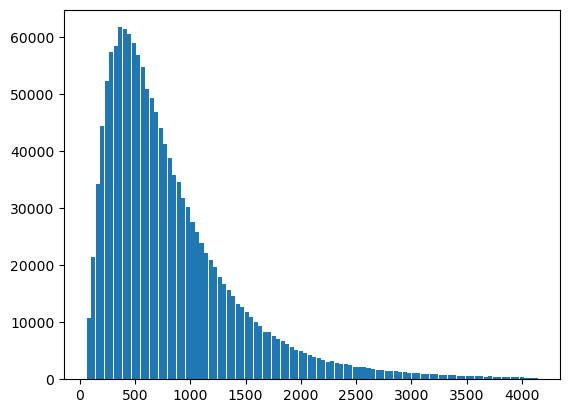

In [8]:
plt.hist(y, bins=100, rwidth=0.9)
plt.show()

(1442663, 24)
(1442663, 24)
(1435463, 24)
(1442663, 27)


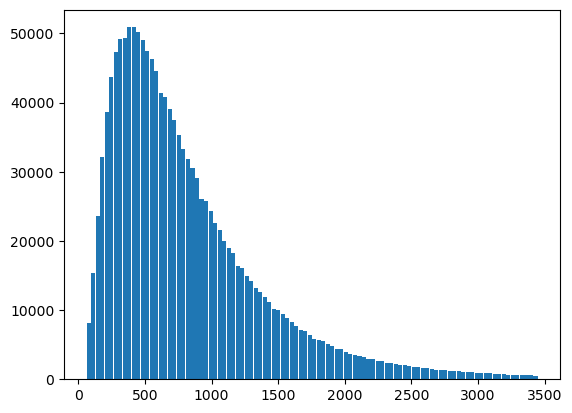

count   1435463.000000
mean        812.408177
std         574.502822
min          60.000000
25%         399.000000
50%         660.000000
75%        1061.000000
max        3448.000000
Name: trip_duration, dtype: float64

In [4]:
# Read in raw data
df = pd.read_csv(data_path + '/train_clean.csv')

# Drop trips less than 60 seconds
df = df[df['trip_duration'] >= 60]

# Get coordinates from json
json_file_path = './misc/lat_long_bounds.json'
with open(json_file_path, 'r') as json_file:
    # Load the JSON data from the file
    coords = json.load(json_file)

# Get rid of lat long outliers
print(df.shape)
df = df[(df['pickup_latitude'] >= coords['lat']['min']) & (df['pickup_latitude'] <= coords['lat']['max'])]
df = df[(df['pickup_longitude'] >= coords['lon']['min']) & (df['pickup_longitude'] <= coords['lon']['max'])]

# Keep only <99.5% of trip duration
print(df.shape)
df1 = df[df['trip_duration'] <= df['trip_duration'].quantile(0.995)]
print(df1.shape)
print(X.shape)

# Plot histogram of trip duration
plt.hist(df1['trip_duration'], bins=100, rwidth=0.9)
plt.show()

df1.trip_duration.describe()


In [81]:
# Train test split
X_c = X.drop(columns=['pickup_datetime'])
X_c = pd.get_dummies(X_c, columns=['pickup_period'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_c, y, test_size=0.2, random_state=42)

# Grid search for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 2],
    'lambda': [0.5, 0.4],
    'alpha': [0.5, 0.4],
    'objective': ['reg:squarederror', 'reg:squaredlogerror']
}
xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=4, n_jobs=-1)
grid_search.fit(X_train, y_train)



# Evaluate based on Root Mean Squared Logarithmic Error.
y_pred = grid_search.predict(X_test)
print(mean_squared_log_error(y_test, y_pred, squared=False))


0.525662602679601


<h3>Doing some basic data analysis</h3>

Task:
<ul>
<li>✅ Get most common pickup and dropoff locations.</li>
<li>Find the number of rows and columns</li>
<li>Find the data statistics</li>
</ul>

In [49]:
# Get the most common pickup longitude and latitude
pop_p_lat = X_c.pickup_latitude.value_counts().index[0]
pop_p_long = X_c[X_c.pickup_latitude == pop_p_lat].pickup_longitude.value_counts().index[0]

# Most common pickup location
com_pickup = (pop_p_lat, pop_p_long)  # This is actually the airport, so that makes sense.

# Get the most common dropoff latitude and longitude 
pop_d_lat = X_c.dropoff_latitude.value_counts().index[0]
pop_d_long = X_c[X_c.dropoff_latitude == pop_d_lat].dropoff_longitude.value_counts().index[0]

# Most common dropoff location
com_dropoff = (pop_d_lat, pop_d_long)  # This is actually the airport, so that makes sense.
com_dropoff

(40.774311, -73.872787)

In [53]:
# Find most common drop off location when pickup location is the airport
drop_lat_after_aiport = X_c[(X_c.pickup_latitude == pop_p_lat) & (X_c.pickup_longitude == pop_p_long)].dropoff_latitude.value_counts()#.index[0]
# drop_long_after_aiport = X_c[X_c.pickup_latitude == pop_p_lat][X_c.dropoff_latitude == drop_lat_after_aiport].dropoff_longitude.value_counts().index[0]
drop_lat_after_aiport

40.668980    1
40.673012    1
40.757832    1
40.642849    1
40.762131    1
40.738796    1
40.750011    1
40.783730    1
40.691589    1
40.802757    1
40.758480    1
40.770809    1
Name: dropoff_latitude, dtype: int64